In [6]:
# load and process data
import os
from importlib import reload
import cv2
import torch
import imageio
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation
import gc

from model_args import aot_args,sam_args,segtracker_args

from wbtool.show import wshow
from wbtool import file_misc as fm
from wbtool import use_models
import proc_data
import numpy as np

vid = np.load('/home/wb/samba_dir/cells_brightfield/leadingcell-WB-entirespan/B1ROI1.npy')
vid = proc_data.value_modify(vid)

ids,coords = proc_data.read_coords_from_csv('/home/wb/samba_dir/cells_brightfield/leadingcell-WB-entirespan/Results_B1ROI1.csv')



(904, 1224, 3)


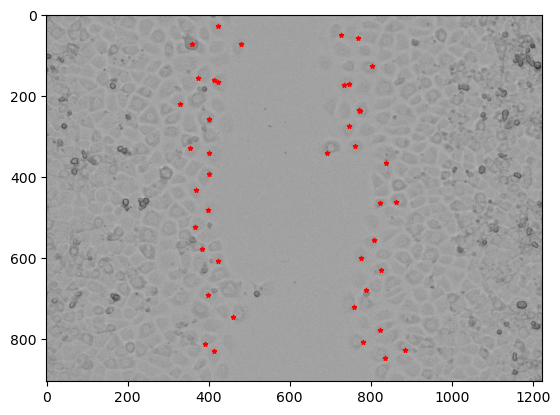

In [2]:
importlib.reload(show)
fid = 20
point_prompt = coords[fid]
obj_mode = np.ones((len(point_prompt), 1))
frame = vid[fid]
frame = proc_data.value_modify(frame)
print(frame.shape)

show.overlay_point(frame, point_prompt)

In [8]:
import SegTracker
from model_args import aot_args,sam_args,segtracker_args
# import SegTracker #import SegTracker
# importlib.reload(SegTracker)
print(sam_args)
sam_args['generator_args'] = {
        'points_per_side': 30,
        'pred_iou_thresh': 0.8,
        'stability_score_thresh': 0.9,
        'crop_n_layers': 1,
        'crop_n_points_downscale_factor': 2,
        'min_mask_region_area': 200,
    }

# segtracker = SegTracker.SegTracker(segtracker_args,sam_args,aot_args)
SA = use_models.cv.sam_agent('prompt')


{'sam_checkpoint': '/home/wb/wb_data/model_parameter_storage/SAM/sam_vit_h_4b8939.pth', 'model_type': 'vit_h', 'generator_args': {'points_per_side': 16, 'pred_iou_thresh': 0.8, 'stability_score_thresh': 0.9, 'crop_n_layers': 1, 'crop_n_points_downscale_factor': 2, 'min_mask_region_area': 200}, 'gpu_id': 0}


In [11]:
### Generate Results for the Whole Video
from skimage import morphology
from onevision import morphology as ovmorph
from onevision import morph_proc
import aux
reload(proc_data)
reload(ovmorph)

segtracker_args = {
    'sam_gap': 1, # the interval to run sam to segment new objects
    'min_area': 20, # minimal mask area to add a new mask as a new object
    'max_obj_num': 255, # maximal object number to track in a video
    'min_new_obj_iou': 0.8, # the area of a new object in the background should > 80% 
    'new_replace_iou_min': 0.5,
    'remain_remove_max':0.4,
    'min_obj_area_ratio':0.0001,
    'max_obj_area_ratio':0.01
}

# output masks
output_dir = '/home/wb/samba_dir/indev/results' #io_args['output_mask_dir']
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# grounding_caption = "cell"
# box_threshold, text_threshold, box_size_threshold, reset_image = 0.02, 0.02, 0.05, True

fnum = len(vid)

# get segmentation results of each frame.
# (this is independent of tracking activity)


pred_list = []

# pred_list.append(pred_mask)


segtracker = SegTracker.SegTracker(segtracker_args,sam_args,aot_args)
segtracker.restart_tracker()   # 调用的是aot_tracker/AOTTracker function, AOT模型自身的restart要求.

torch.cuda.empty_cache()
gc.collect()
# tms,sms,nobs=[],[],[]
# with torch.cuda.amp.autocast():
for frame_idx in range(fnum):
    point_prompt = coords[frame_idx]
    obj_mode = np.ones((len(point_prompt), 1))
    frame = vid[frame_idx]
    frame = proc_data.value_modify(frame)
    frame_area = frame.shape[0] * frame.shape[1]

    if frame_idx == 0:
        # if frame_idx !=9:
        #     continue
        # pred_mask = segtracker.seg_with_prompt(frame, point_prompt, obj_mode)
        ms = SA.infer(frame, point_prompt)
        ms = proc_data.filter_mask_by_size(ms, segtracker_args['min_obj_area_ratio'], segtracker_args['max_obj_area_ratio'])
        ms = morph_proc.masks_to_map(ms)
        ms = ovmorph.isolate_object(ms, False)
        pred_mask = ovmorph.filter_object_size(ms, segtracker_args['min_obj_area_ratio'], segtracker_args['max_obj_area_ratio'])
        # print(segtracker.curr_idx)
        segtracker.add_reference(frame, pred_mask)
    elif (frame_idx % segtracker_args['sam_gap']) == 0:

        # 1/2
        # seg_mask = segtracker.seg_with_prompt(frame, point_prompt, obj_mode)
        ms = SA.infer(frame, point_prompt)
        # print(len(ms))
        ms = proc_data.filter_mask_by_size(ms, segtracker_args['min_obj_area_ratio'], segtracker_args['max_obj_area_ratio'])
        ms = morph_proc.masks_to_map(ms)
        # print(ms.shape)
        ms = ovmorph.isolate_object(ms, False)
        seg_mask = ovmorph.filter_object_size(ms, segtracker_args['min_obj_area_ratio'], segtracker_args['max_obj_area_ratio'])
        # 2/2
        # seg_mask,_ = segtracker.detect_and_seg(frame, grounding_caption, box_threshold, text_threshold, box_size_threshold, reset_image)
        # e/2
        # torch.cuda.empty_cache()
        # gc.collect()
        track_mask = segtracker.track(frame)
        # show.wshow(track_mask)
        # show.wshow(seg_mask)
        # find new objects, and update tracker with new objects
        print(len(np.unique(seg_mask)))
        new_obj_mask = aux.find_new_objs(segtracker_args, track_mask, seg_mask, segtracker.curr_idx)
        print(len(np.unique(new_obj_mask)))
        new_obj_mask = seg_mask

        # tms.append(track_mask); sms.append(seg_mask); nobs.append(new_obj_mask)
        
        # show.wshow(new_obj_mask)
        # 1/2
        # pred_mask = track_mask + new_obj_mask
        # 2/2
        # track_mask = ovmorph.isolate_object(track_mask)  #<<<<
        # track_mask = ovmorph.filter_object_size(ms, segtracker_args['min_obj_area_ratio'], segtracker_args['max_obj_area_ratio'])

        # print(new_obj_mask.shape, np.unique(new_obj_mask))
        pred_mask = aux.merge_pt(segtracker_args, track_mask, new_obj_mask)
        # e/2
        # segtracker.restart_tracker()
        segtracker.add_reference(frame, pred_mask)
    else:
        pred_mask = segtracker.track(frame, update_memory=True)
    # torch.cuda.empty_cache()
    # gc.collect()
    proc_data.save_prediction(pred_mask, output_dir, str(frame_idx)+'.png')
    # show.wshow(pred_mask)
    # masked_frame = proc_data.draw_mask(frame,pred_mask)
    
    print("processed frame {}, obj_num {}".format(frame_idx, segtracker.get_obj_num()), end='\r')

print('\nfinished')
# np.save('tms',tms); np.save('sms',sms); np.save('nobs',nobs)


final text_encoder_type: bert-base-uncased
Model loaded from /home/wb/tools/Segment-and-Track-Anything/ckpt/groundingdino_swint_ogc.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight', 'bert.embeddings.position_ids'])
SegTracker has been initialized
8rocessed frame 0, obj_num 7
4
7rocessed frame 1, obj_num 10
3
15ocessed frame 2, obj_num 12
5
14ocessed frame 3, obj_num 19
6
15ocessed frame 4, obj_num 23
6
20ocessed frame 5, obj_num 28
4
18ocessed frame 6, obj_num 34
5
28ocessed frame 7, obj_num 41
8
26ocessed frame 8, obj_num 50
5
28ocessed frame 9, obj_num 53
2
31ocessed frame 10, obj_num 55
4
24ocessed frame 11, obj_num 59
3
19ocessed frame 12, obj_num 63
2
24ocessed frame 13, obj_num 64
3
32ocessed frame 14, obj_num 66
4
32ocessed frame 15, obj_num 72
3
29ocessed frame 16, obj_num 73
1
24ocessed frame 17, obj_num 73
1
26ocessed frame 18, obj_num 73
3
24ocessed frame 19, obj_num 78
2
23ocessed frame 20, obj_num 80
2
27ocessed frame 21, obj_num 82
2
28ocess

[19.0, 27.0, 23.0, 37.0, 29.0]


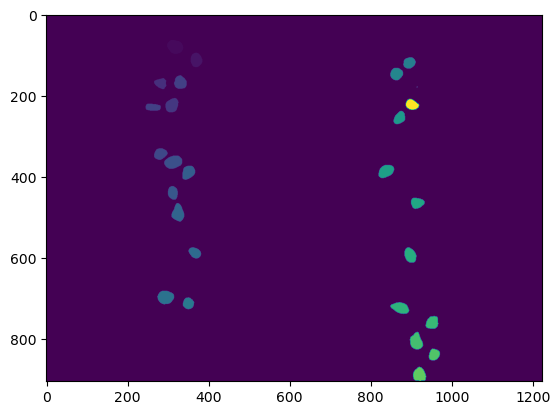

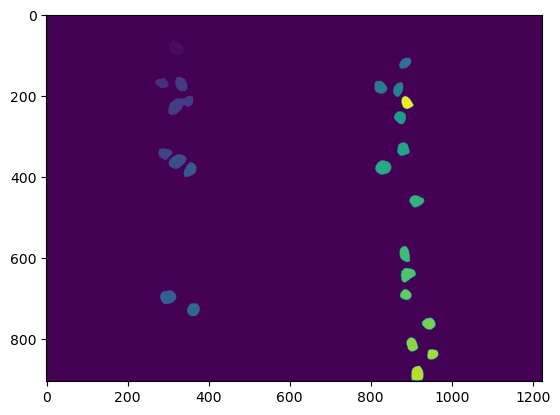

In [24]:
# print(sr[3].shape)
X = [merge_mask(it) for it in sr]

print([it.max() for it in X])
show.wshow(X[3])
show.wshow(X[4])
# # print(sum(sum(sr[0])))
# # print(sum(sum(sr[4])))

供参考的SegTracker函数

刘平版：
def detect_and_seg_pt(self, origin_frame: np.ndarray, coords, modes):
    '''
    Using Grounding-DINO to detect object acc Text-prompts
    Retrun:
        refined_merged_mask: numpy array (h, w)
        annotated_frame: numpy array (h, w, 3)
    '''
            # backup id and origin-merged-mask
    bc_id = self.curr_idx
    bc_mask = self.origin_merged_mask
    
    # get annotated_frame and boxes
    # annotated_frame, boxes = self.detector.run_grounding(origin_frame, grounding_caption, box_threshold, text_threshold)
    for i in range(len(coords)):
        pt = coords[i].reshape([1,2])
        mode = modes[i]
        # if (bbox[1][0] - bbox[0][0]) * (bbox[1][1] - bbox[0][1]) > annotated_frame.shape[0] * annotated_frame.shape[1] * box_size_threshold:
        #     continue
        interactive_mask = self.sam.segment_with_click(origin_frame, pt, mode)

        mask = interactive_mask.copy()
        if(mask.sum(1).sum(0)/(mask.shape[0]*mask.shape[1]) < 0.01): 
            refined_merged_mask = self.add_mask(interactive_mask)
            self.update_origin_merged_mask(refined_merged_mask)
            self.curr_idx += 1

    # reset origin_mask
    self.reset_origin_merged_mask(bc_mask, bc_id)

    return refined_merged_mask

最终版：
    def detect_and_seg_pt(self, frame: np.ndarray, coords, modes):
        '''
        Using Grounding-DINO to detect object acc Text-prompts
        Retrun:
            refined_merged_mask: numpy array (h, w)
            annotated_frame: numpy array (h, w, 3)
        '''
        # backup id and origin-merged-mask
        bc_id = self.curr_idx
        bc_mask = self.origin_merged_mask
    
        # get annotated_frame and boxes
        # annotated_frame, boxes = self.detector.run_grounding(frame, grounding_caption, box_threshold, text_threshold)
        cnum = len(coords)
        imgarea = frame.shape[0]*frame.shape[1]
        # ims = []
        refined_merged_mask = self.add_mask(np.zeros(frame.shape[:2], dtype=np.uint8))
        for k in range(cnum):
            # if (bbox[1][0] - bbox[0][0]) * (bbox[1][1] - bbox[0][1]) > annotated_frame.shape[0] * annotated_frame.shape[1] * box_size_threshold:
            #     continue
            interactive_mask = self.sam.segment_with_click(frame, coords[k:k+1], modes[k], True)
            # ims.append(interactive_mask.copy())
            
            if interactive_mask.sum(1).sum(0)/imgarea < 0.01:
                refined_merged_mask = self.add_mask(interactive_mask)  #在self.origin_merged_mask 的基础上，根据输入修改得到返回值。
                self.update_origin_merged_mask(refined_merged_mask)
                self.curr_idx += 1

        # reset origin_mask
        self.reset_origin_merged_mask(bc_mask, bc_id)

        return refined_merged_mask